# Workshop Tutorial: Optimizers

In this tutorial we will continue the fitting process by optimizing our results from the previous tutorial. 

Specifically we will cover:

- optimizer.nelder_mead

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorials:

* [Advanced: Nelder-Mead Optimizer](http://phoebe-project.org/docs/2.3/tutorials/nelder_mead)



In [1]:
import phoebe
from phoebe import u # units
import numpy as np
# Mac users may need to turn multi-processing off
#phoebe.multiprocessing_off() 
logger = phoebe.logger('error')

You may need to update the path below to where you saved the bundle from the previous tutorial, or you can download [after_estimators.bundle](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/after_estimators.bundle).

In [2]:
#Load Previous Bundle
b = phoebe.open('data/synthetic/after_estimators.bundle')

/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10382: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._value = np.array(value)


In [3]:
#First let's look at our final fit from the previous bundle
b.run_compute('phoebe01', model='after_estimators')

100%|██████████| 200/200 [00:06<00:00, 28.93it/s]


<ParameterSet: 8 parameters | kinds: rv, lc>

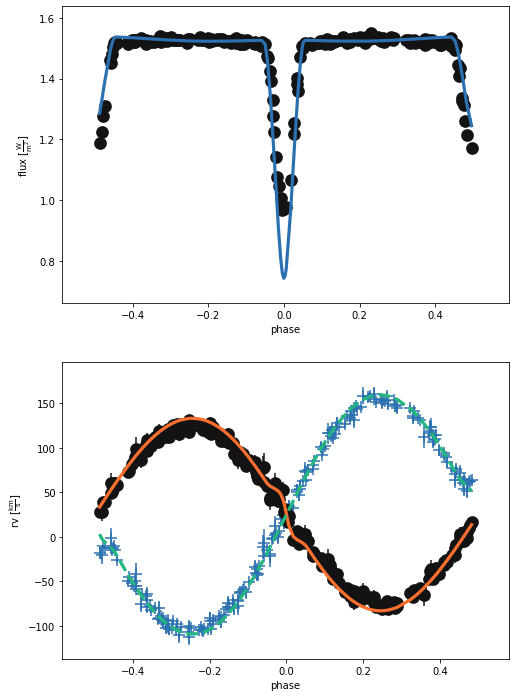

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [4]:
b.plot(model='after_estimators', x='phases', show=True)

In [5]:
#Create a new compute parameter set 
b.add_compute(compute='nm_fit')

<ParameterSet: 40 parameters | datasets: rv01, _default, lc01>

In [6]:
# Change fitting options for faster model computation
b.set_value('irrad_method', compute='nm_fit', value='none')
b.set_value_all('rv_method', compute='nm_fit', value='dynamical')
b.set_value_all('distortion_method', compute='nm_fit', value='sphere')


In [7]:
# Add compute phases and reduce model computation speed
b.flip_constraint('compute_phases@rv01', solve_for='compute_times@rv01')
comp_phases = np.linspace(0,1,25)
b.set_value_all('compute_phases', dataset='rv01', value=comp_phases)

Phoebe has three optimizer methods: 

conjugate gradient (optimizer.cg)

powell (optimizer.powell) 

nelder_mead (optimizer.nelder_mead) 

In most cases nelder_mead is the most efficient and useful so this is the one we will use moving forward. However, the logic is almost identical if you would like to try a different one. 

In [8]:
#Add optimizer
b.add_solver('optimizer.nelder_mead',  solver='nm_solver', compute='nm_fit')

<ParameterSet: 14 parameters | qualifiers: comments, progress_every_niters, continue_from, use_server, priors, compute, expose_lnprobabilities, adaptive, xatol, fatol, maxiter, priors_combine, initial_values, fit_parameters>

In [9]:

#change max iterations
b.set_value('maxiter', solver='nm_solver', value=20)

In [10]:
#disable lc and fit rvs
b.disable_dataset('lc01')

<ParameterSet: 18 parameters | components: binary, primary, secondary>

In [11]:
#check rv values and adjust
print(b.filter('ecc@binary'))

ParameterSet: 1 parameters
             ecc@binary@component: 0.014982550244806693


In [12]:
#set ecc to 0
b.set_value('ecc', component='binary', value=0.)


In [13]:
#set fit parameters
fit_params = ['vgamma@system', 't0_supconj@binary', 'q@binary', 'asini@binary']
b.set_value('fit_parameters', fit_params)

In [14]:
#run solver
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


<ParameterSet: 11 parameters | qualifiers: message, adopt_parameters, fitted_units, comments, adopt_values, adopt_distributions, success, fitted_twigs, initial_values, niter, fitted_values>

We can check on the reasonableness of the fit with the keyword trial_run = True. This let's us see what the new values are without having to adopt them first. 

In [15]:
#check updated fitted parameters
print(b.adopt_solution('nm_solution', trial_run=True))


ParameterSet: 4 parameters
                    vgamma@system: 25.867804341635086 km / s
   t0_supconj@binary@orbit@com...: 1.2287354121464946 d
         q@binary@orbit@component: 0.7548477466076525
     asini@binary@orbit@component: 7.850711857471909 solRad


In [16]:
#compute model and check fit
b.run_compute('nm_fit', solution='nm_solution', model='after_nm', sample_num=1)

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


<ParameterSet: 10 parameters | components: primary, secondary>

You'll notice a new parameter in run computer "sample_num". When you are computing values from a solution it will generally compute multiple times, which is useful when the parameters have an associated distribution.  This will be useful for mcmc, but for now we will just set it to 1.

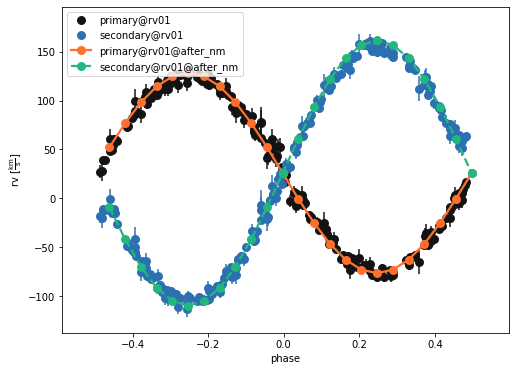

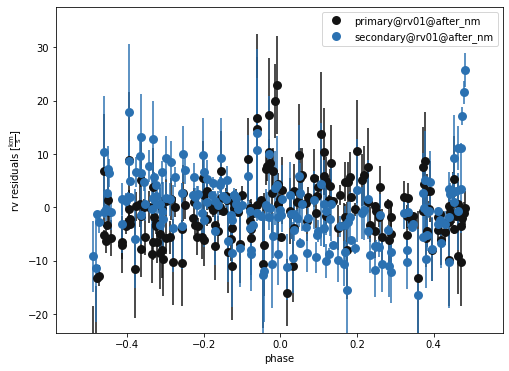

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [17]:
b.plot(kind='rv', model='after_nm', x='phases', show=True, legend=True, marker = 'o')
b.plot( kind='rv', model='after_nm', x='phases', y='residuals', show=True, legend=True, marker = 'o')

In [18]:
b.adopt_solution('nm_solution')


<ParameterSet: 22 parameters | contexts: component, dataset, system>

In [19]:
#fit lc
b.disable_dataset('rv01')
b.enable_dataset('lc01')

<ParameterSet: 18 parameters | components: binary, primary, secondary>

Now we want to reduce the number of points that we need to compute. One easy way to do this is to only fit the eclipses. So let's  use our previous lc geometry solution to mask everything else. 

In [20]:
print(b.filter('lcgeom_solution'))

ParameterSet: 21 parameters
R  orbit@lcgeom@lcgeom_solutio...: binary
R  input_phases@lcgeom@lcgeom_...: [-0.49964091 -0.48263891
 -0.4768434  ...  0.47976384
  0.48413045  0.48728185]
R  input_fluxes@lcgeom@lcgeom_...: [0.76947627 0.78081505
 0.8043889  ... 0.86360669
 0.82775647 0.79882824]
R  input_sigmas@lcgeom@lcgeom_...: [0.00328515 0.00328515
 0.00328515 ... 0.00328515
 0.00328515 0.00328515]
R  analytic_phases@lcgeom@lcge...: [-0.5   -0.495 -0.49  ...
  0.49   0.495  0.5  ]
R  analytic_fluxes@lcgeom_solu...: {'C': [0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.9683942441892823, 0.968394244

In [21]:
adopt_parameters = ['mask_phases']
b.set_value(solution = 'lcgeom_solution', qualifier='adopt_parameters', 
            value=adopt_parameters)
b.adopt_solution('lcgeom_solution')

<ParameterSet: 1 parameters>

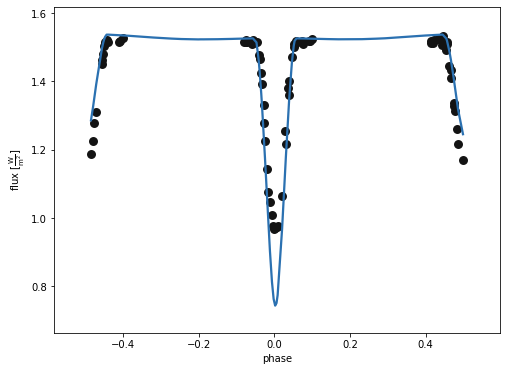

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [22]:
b.plot(kind='lc', model='after_estimators', x='phases', show='True')

In [23]:
#switch back from requivsumfrac to a primary radius
b.flip_constraint('requiv@primary', solve_for='requivsumfrac@binary')


<ConstraintParameter: {requivsumfrac@binary@component} = ({requiv@primary@component} + {requiv@secondary@component}) / {sma@binary@component} (solar units) => 0.34511581409961234>

In [24]:
fit_params = ['teffratio@binary', 't0_supconj@binary', 'incl@binary']
b.set_value('fit_parameters', fit_params)

In [25]:
#change max iterations
b.set_value('maxiter', solver='nm_solver', value=15)

In [26]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 15/15 [03:06<00:00, 12.40s/it]


<ParameterSet: 11 parameters | qualifiers: message, adopt_parameters, fitted_units, comments, adopt_values, adopt_distributions, success, fitted_twigs, initial_values, niter, fitted_values>

In [27]:
print(b.adopt_solution('nm_solution', trial_run=True))


ParameterSet: 3 parameters
   teffratio@binary@orbit@comp...: 0.9081414620976411
   t0_supconj@binary@orbit@com...: 1.2323959604723704 d
      incl@binary@orbit@component: 82.89348311634393 deg


100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


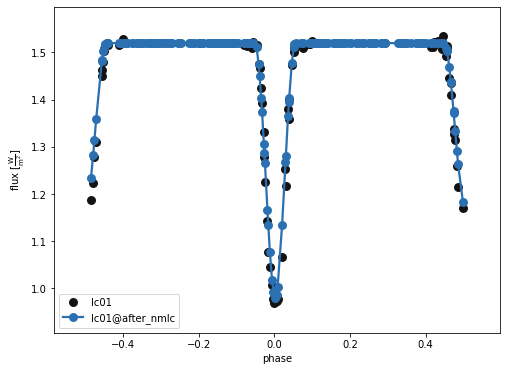

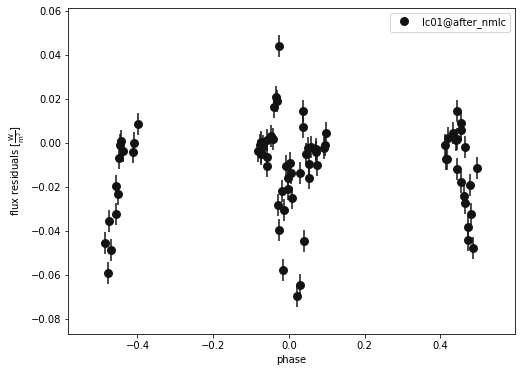

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [28]:
b.run_compute('nm_fit', solution='nm_solution', model='after_nmlc', sample_num=1)

b.plot(kind='lc', model='after_nmlc', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='after_nmlc', x='phases', y='residuals', show=True, legend=True, marker = 'o')


In [29]:
b.adopt_solution('nm_solution')

<ParameterSet: 24 parameters | contexts: component, dataset>

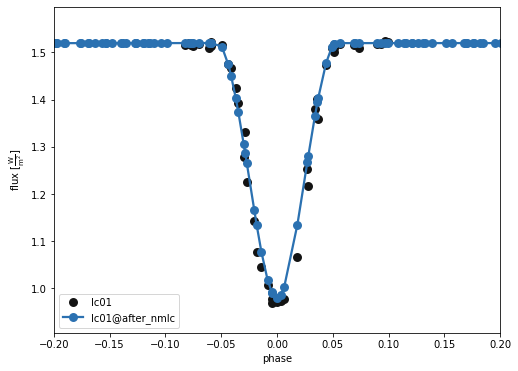

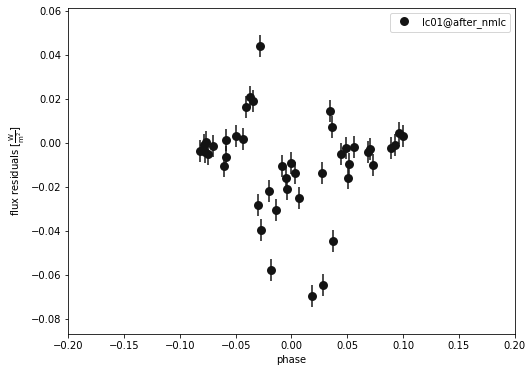

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [30]:
#look more closely at the primary eclipse
b.plot(kind='lc', x='phases', model='after_nmlc', xlim=[-0.2,0.2], show=True, legend=True, marker = 'o')
b.plot(kind='lc', x='phases', model='after_nmlc', xlim=[-0.2,0.2], y='residuals', show=True, legend=True, marker = 'o')

# Exercise

Combine both light and rv curves to achieve a better fit, primarily within the eclipse. Hint: It's often better to fit a small number of parameters first. 